## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

In [5]:
import pandas as pd

In [6]:
import numpy as np

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
import matplotlib.pyplot as plt

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
from sklearn.tree import DecisionTreeRegressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
from sklearn.metrics import mean_absolute_error

In [15]:
import warnings
warnings.filterwarnings('ignore')

# 1. Подготовка

In [16]:
orders = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

In [17]:
orders.head(40)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [19]:
orders.describe

<bound method NDFrame.describe of                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]>

Данные в порядке, обработка не требуется.

In [20]:
orders.sort_index(inplace=True) #отсортируем в хронологическом порядке

In [21]:
orders = orders.resample('1H').mean() #ресемплирование со средним по каждому часу

In [22]:
orders.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667
2018-03-01 05:00:00,1.000000
2018-03-01 06:00:00,2.000000
2018-03-01 07:00:00,2.500000
2018-03-01 08:00:00,5.666667


# 2. Анализ

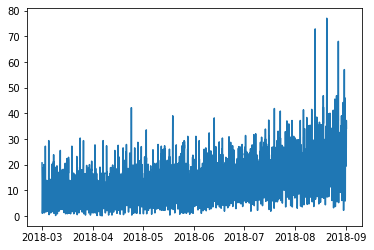

In [23]:
plt.plot(orders) # смотрим распределение количества заказов

По графику видно, что временной ряд нельзя назвать стационарным, т.к. его распределение изменяется со временем.

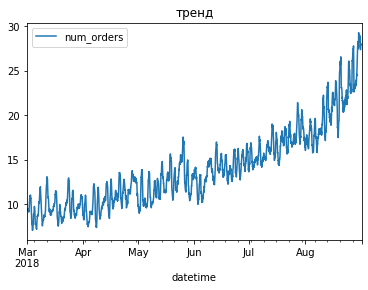

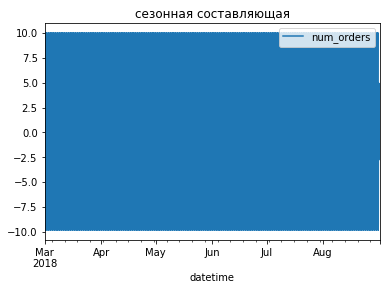

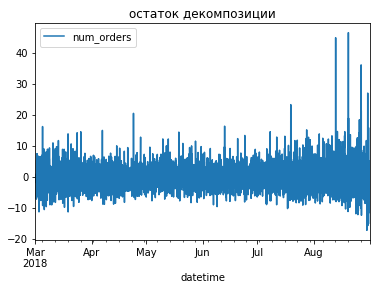

In [24]:
decomposed = seasonal_decompose(orders) # смортим графики на тренды и сезонность
decomposed.trend.plot() 
plt.title('тренд')
decomposed.seasonal.plot()
plt.title('сезонная составляющая')
decomposed.resid.plot()
plt.title('остаток декомпозиции')
plt.show()

Видим следующее:
    - Тренд  — плавное увеличение количества заказов. 
    - Сезонность в данном виде не проявляется.

In [25]:
#orders['mean'] = orders['num_orders'].rolling(15).mean()
#orders['std'] = orders['num_orders'].rolling(15).std()

In [22]:
#orders.plot()

# 3. Обучение

In [26]:
#создадим функцию, чтобы добавить календарные признаки к таблице
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['minute'] = data.index.minute
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [27]:
make_features(orders, 5, 1) # добавим столбцы признаков

In [28]:
train, valid = train_test_split(orders, shuffle=False, test_size=0.2) # делим на выборки в соотношении 8:1:1.
train = train.dropna()
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)
valid = valid.dropna()

target_train = train['num_orders']
features_train = train.drop(columns=['num_orders'] , axis=1)
target_valid = valid['num_orders']
features_valid = valid.drop(columns=['num_orders'] , axis=1)
target_test = test['num_orders']
features_test = test.drop(columns=['num_orders'] , axis=1)

In [29]:
model = LinearRegression() # обучаем модель линейной регрессии
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
predictions_valid = model.predict(features_valid)
print("RMSE обучающей выборки:", mean_squared_error(target_train, predictions_train) **0.5)
print("RMSE валидационной выборки: ", mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE обучающей выборки: 4.834878377434334
RMSE валидационной выборки:  6.753888363305243


max_depth = 1 :5.3130026802201655 8.569940229039904
max_depth = 2 :4.845570611612969 8.228256397671636
max_depth = 3 :4.49820346735707 7.449127573272136
max_depth = 4 :4.265141762307007 7.002007299744945
max_depth = 5 :3.9474518937955834 6.3096861905839505
max_depth = 6 :3.6853921555773246 6.116980555042102
max_depth = 7 :3.45243841398446 6.296126510565672
max_depth = 8 :3.1423348061161147 6.501202722198514
max_depth = 9 :2.841057662726392 6.488715527651035
max_depth = 10 :2.5479991442291516 6.67111025544327
max_depth = 11 :2.2327007856022196 6.621312689696323
max_depth = 12 :1.9239639659913932 6.601076141890518
max_depth = 13 :1.6138384983910472 6.822566033212801
max_depth = 14 :1.3177668590823657 6.820096886468116
max_depth = 15 :1.0181298865081911 7.084350884830291
max_depth = 16 :0.7601465416981729 7.065401947273422
max_depth = 17 :0.5228580769489293 7.202728303320337
max_depth = 18 :0.3501050003291366 7.089150855541653
max_depth = 19 :0.21682554326925169 6.968744187479398


Text(0.5, 0, 'max depth')

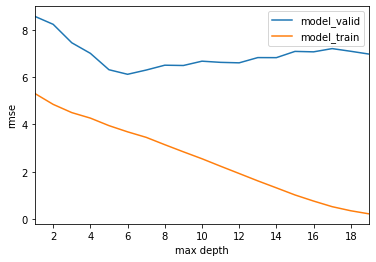

In [30]:
model_train = {} # обучаем модель регрессии деревом решений
model_valid = {}
for depth in range(1, 20):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(features_train, target_train)
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)
        
    model_train[depth] = mean_squared_error(target_train, predicted_train)**0.5 
    model_valid[depth] = mean_squared_error(target_valid, predicted_valid)**0.5
    print('max_depth =', depth, ':', end='')
    print( mean_squared_error(target_train, predicted_train)**0.5, mean_squared_error(target_valid, predicted_valid)**0.5)

model_valid = pd.Series(model_valid)
model_train = pd.Series(model_train)
model_rmse = pd.DataFrame({'model_valid': model_valid, 'model_train': model_train})
model_rmse.plot()
plt.ylabel('rmse')
plt.xlabel('max depth')

Лучшее значение rmse_train=3.66 и rmse_valid=6.01 при max depth=6, дальше модель переобучается.

n_estimators = 1 :3.1494740683723133 6.7558049076126725
n_estimators = 2 :2.361179397527445 6.439788120794347
n_estimators = 3 :2.029487982829812 6.012083873786744
n_estimators = 4 :1.8343517074325786 5.978389311779352
n_estimators = 5 :1.7585783286746106 5.839220687756352
n_estimators = 6 :1.6987788275339777 5.76074824937833
n_estimators = 7 :1.6492179755644285 5.806682476554729
n_estimators = 8 :1.6173334617517519 5.765674933548886
n_estimators = 9 :1.5865197375973072 5.743952741609265
n_estimators = 10 :1.5696060556180074 5.680031927271317
n_estimators = 11 :1.5533989335413478 5.638058831783202
n_estimators = 12 :1.532635319325868 5.58751936370664
n_estimators = 13 :1.5240219055989195 5.606021150844021
n_estimators = 14 :1.507953714580266 5.575367635799913
n_estimators = 15 :1.4960023082159806 5.5826313064023205
n_estimators = 16 :1.4845012786870952 5.568523565901197
n_estimators = 17 :1.4692245326810056 5.54416529344772
n_estimators = 18 :1.4510281594211185 5.5112591659585
n_estima

Text(0.5, 0, 'n_estimators')

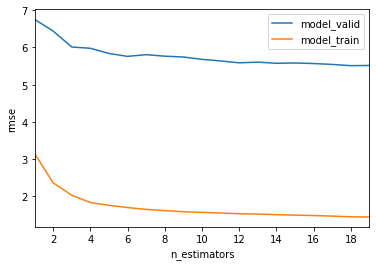

In [31]:
model_train = {}
model_valid = {}
for estim in range(1, 20): # проверяем модель регреccии для случайного леса
    model = RandomForestRegressor(n_estimators=estim, random_state=12345)
    model.fit(features_train, target_train)
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)
        
    model_train[estim] = mean_squared_error(target_train, predicted_train)**0.5 
    model_valid[estim] = mean_squared_error(target_valid, predicted_valid)**0.5
    print('n_estimators =', estim, ':', end='')
    print( mean_squared_error(target_train, predicted_train)**0.5, mean_squared_error(target_valid, predicted_valid)**0.5)

model_valid = pd.Series(model_valid)
model_train = pd.Series(model_train)
model_rmse = pd.DataFrame({'model_valid': model_valid, 'model_train': model_train})
model_rmse.plot()
plt.ylabel('rmse')
plt.xlabel('n_estimators')

Лучшее значение rmse_train=1.93 и rmse_valid=5.97 при n_estimators=4, дальше модель переобучается.

# 4. Тестирование

Протестируем модели для лучших показателей.

In [32]:
model = LinearRegression() #  модель линейной регрессии
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions_test)**0.5)

RMSE тестовой выборки:  8.807393450587277


In [33]:
model = DecisionTreeRegressor(max_depth=6) #  модель решающего дерева
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions_test)**0.5)

RMSE тестовой выборки:  10.035983151877533


In [34]:
model = RandomForestRegressor(n_estimators=4) #  модель случайного леса
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, predictions_test)**0.5)

RMSE тестовой выборки:  8.760252648070095


Оценим лучшую модель  предыдущим значением ряда и найдем для этого прогноза значение MAE.

In [35]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("MAE:", mean_absolute_error(test, pred_previous))

MAE: 4.547071392659628


## Выводы

В ходе проделанной работы были данные по количесту заказов обработаны как временные ряды и проанализированы.

Анализ показал тренд по увеличению количества вызовов в на протяжении всего периода, сезонность не выявленя на данном интервале. По общему графику количествов вызовор видно, что временной ряд нельзя назвать стационарным, т.к. его распределение изменяется со временем.

Были обучены разные модели с различными гиперпараметрами. 
    - для линейной регрессии получили: RMSE обучающей выборки: 4.83, RMSE валидационной выборки:  6.75
    - для дерева решений rmse_train=3.66 и rmse_valid=6.01 при max depth=6, дальше модель переобучается
    - для случайного леса rmse_train=1.93 и rmse_valid=5.97 при n_estimators=4, дальше модель переобучается.

Проверили модели с лучшими гиперпараметрами на тестовой выборке размером 10% от исходных данных.

Для линейной регрессии получили RMSE 8.81, для дерева решений - 9.97, для случайного леса - 8.6 - самое лучшее значение (при проверке адекватности MAE: 4.54).
